# Vérification visuelle GPU vs OAK

Ce notebook compare visuellement les détections GPU (pixel-perfect) et OAK sur quelques images.
L'objectif est de vérifier que le décodage des boxes est cohérent entre les deux pipelines.

In [9]:
import sys
sys.path.insert(0, '..')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import depthai as dai

# Configuration
IMGSZ = 640
CONF_THR = 0.25  # seuil de confiance pour affichage
NMS_IOU = 0.70

# Chemins modèles (à ajuster)
GPU_MODEL = '/home/nathan/Documents/GitHub/3d_edge_object_detection/models/base/yolo11n.pt'
OAK_MODEL = '/home/nathan/Documents/GitHub/3d_edge_object_detection/models/base/yolo11n_openvino_2022.1_6shave.blob'
NUM_CLASSES = 80

In [10]:
# Charger quelques images de test
from scripts.benchmark import load_coco128_dataset, letterbox

dataset = load_coco128_dataset('coco128')
test_images = dataset[:5]  # 5 premières images
print(f"Images de test: {[Path(s['image_path']).name for s in test_images]}")

[Dataset] coco128/train2017 (equite multi-hardware)
[Dataset] Chemin images: /home/nathan/Documents/education/master_2/cours/deep_learning_for_image/TP6/datasets/coco128/images/train2017
[Dataset] Chemin labels: /home/nathan/Documents/education/master_2/cours/deep_learning_for_image/TP6/datasets/coco128/labels/train2017
[Dataset] Images trouvees: 128 (attendu: 128)
Images de test: ['000000000009.jpg', '000000000025.jpg', '000000000030.jpg', '000000000034.jpg', '000000000036.jpg']


In [11]:
def run_gpu_inference(model, img, conf_thr=0.25):
    """Inference GPU avec letterbox pixel-perfect."""
    orig_h, orig_w = img.shape[:2]
    img_lb, ratio, (dw, dh) = letterbox(img, (IMGSZ, IMGSZ))
    
    result = model.predict(
        img_lb,
        imgsz=IMGSZ,
        conf=conf_thr,
        iou=NMS_IOU,
        device=0,
        verbose=False,
    )[0]
    
    preds = []
    for b in result.boxes:
        x1, y1, x2, y2 = b.xyxy[0].tolist()
        # Reverse letterbox
        x1 = (x1 - dw) / ratio[0]
        y1 = (y1 - dh) / ratio[1]
        x2 = (x2 - dw) / ratio[0]
        y2 = (y2 - dh) / ratio[1]
        preds.append({
            'box': [x1, y1, x2, y2],  # pixels absolus
            'class_id': int(b.cls.item()),
            'confidence': float(b.conf.item()),
        })
    return preds

In [12]:
def run_oak_inference(device, q_in, q_out, img, num_classes, conf_thr=0.25):
    """Inference OAK."""
    orig_h, orig_w = img.shape[:2]
    img_lb, ratio, (dw, dh) = letterbox(img, (IMGSZ, IMGSZ))
    
    # Preprocess
    img_chw = np.ascontiguousarray(img_lb.transpose(2, 0, 1))
    
    # Frame DepthAI
    dai_frame = dai.ImgFrame()
    dai_frame.setWidth(IMGSZ)
    dai_frame.setHeight(IMGSZ)
    dai_frame.setType(dai.ImgFrame.Type.BGR888p)
    dai_frame.setData(img_chw.reshape(-1))
    
    # Inference
    q_in.send(dai_frame)
    in_nn = q_out.get()
    
    # Decode
    output_layers = in_nn.getAllLayerNames()
    raw_data = np.array(in_nn.getLayerFp16(output_layers[0]))
    data = raw_data.reshape(num_classes + 4, -1).transpose()
    
    scores = np.max(data[:, 4:], axis=1)
    mask = scores > conf_thr
    data_filtered = data[mask]
    scores_filtered = scores[mask]
    
    preds = []
    if len(scores_filtered) > 0:
        class_ids = np.argmax(data_filtered[:, 4:], axis=1)
        
        boxes_nms = []
        boxes_xyxy = []
        for j in range(len(scores_filtered)):
            cx, cy, w, h = data_filtered[j, 0:4]
            x = cx - (w / 2)
            y = cy - (h / 2)
            boxes_nms.append([x, y, w, h])
            boxes_xyxy.append([x, y, x + w, y + h])
        
        # NMS
        if hasattr(cv2.dnn, 'NMSBoxesBatched'):
            indices = cv2.dnn.NMSBoxesBatched(
                boxes_nms, scores_filtered.tolist(), class_ids.tolist(),
                conf_thr, NMS_IOU
            )
        else:
            indices = cv2.dnn.NMSBoxes(boxes_nms, scores_filtered.tolist(), conf_thr, NMS_IOU)
        
        indices = np.array(indices).reshape(-1)
        for idx in indices:
            box = list(boxes_xyxy[idx])
            # Reverse letterbox
            box[0] = (box[0] - dw) / ratio[0]
            box[1] = (box[1] - dh) / ratio[1]
            box[2] = (box[2] - dw) / ratio[0]
            box[3] = (box[3] - dh) / ratio[1]
            preds.append({
                'box': box,  # pixels absolus
                'class_id': int(class_ids[idx]),
                'confidence': float(scores_filtered[idx]),
            })
    return preds

In [13]:
def draw_boxes(img, preds, color, label_prefix=''):
    """Dessine les boxes sur l'image."""
    img_draw = img.copy()
    for p in preds:
        x1, y1, x2, y2 = [int(v) for v in p['box']]
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, 2)
        label = f"{label_prefix}c{p['class_id']}:{p['confidence']:.2f}"
        cv2.putText(img_draw, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    return img_draw

def compute_box_iou(box1, box2):
    """IoU entre deux boxes [x1, y1, x2, y2]."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0

In [14]:
# Charger modèle GPU
print("Chargement modèle GPU...")
gpu_model = YOLO(GPU_MODEL)
print(f"Classes GPU: {len(gpu_model.names)}")

Chargement modèle GPU...
Classes GPU: 80


In [15]:
# Créer pipeline OAK
print("Création pipeline OAK...")
pipeline = dai.Pipeline()

xin = pipeline.create(dai.node.XLinkIn)
xin.setStreamName("input")
xin.setMaxDataSize(IMGSZ * IMGSZ * 3)
xin.setNumFrames(4)

nn = pipeline.create(dai.node.NeuralNetwork)
nn.setBlobPath(OAK_MODEL)
nn.setNumInferenceThreads(2)
xin.out.link(nn.input)

xout = pipeline.create(dai.node.XLinkOut)
xout.setStreamName("nn")
nn.out.link(xout.input)

print("Pipeline OAK prêt.")

Création pipeline OAK...
Pipeline OAK prêt.


Comparaison GPU vs OAK...

[14442C106133DCD600] [1.4] [1.322] [NeuralNetwork(1)] [warning] Network compiled for 6 shaves, maximum available 16, compiling for 8 shaves likely will yield in better performance
=== 000000000009.jpg ===
GPU: 5 detections, OAK: 6 detections

Top-5 boxes GPU vs OAK (IoU matching):
  [1] GPU c45@0.93 box=[309,1,630,237]
      OAK c45@0.92 box=[309,1,630,237]
      IoU=0.997 ✓
  [2] GPU c50@0.84 box=[255,230,568,476]
      OAK c50@0.82 box=[255,230,568,476]
      IoU=0.997 ✓
  [3] GPU c45@0.78 box=[0,190,637,474]
      OAK c45@0.77 box=[0,190,636,474]
      IoU=0.996 ✓
  [4] GPU c45@0.62 box=[1,8,433,394]
      OAK c45@0.61 box=[2,9,434,349]
      IoU=0.877 ⚠️ ATTENTION
  [5] GPU c50@0.37 box=[328,410,428,480]
      OAK c50@0.38 box=[328,410,427,480]
      IoU=0.990 ✓


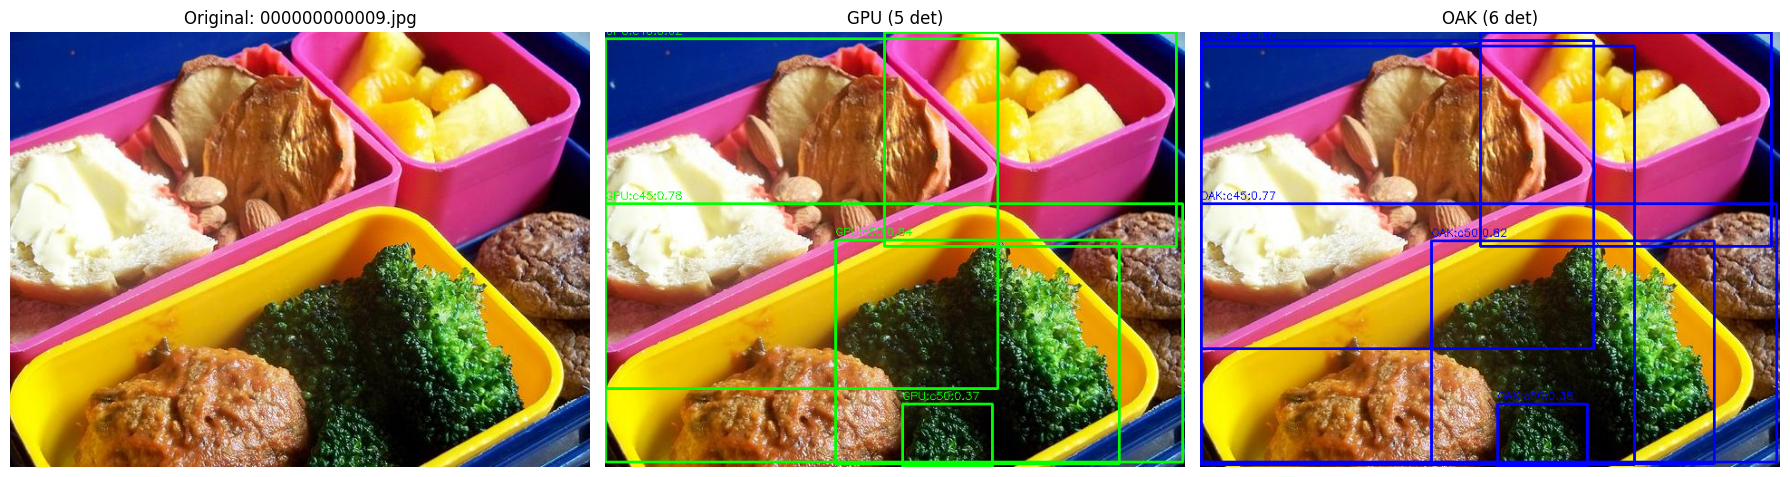



=== 000000000025.jpg ===
GPU: 1 detections, OAK: 1 detections

Top-5 boxes GPU vs OAK (IoU matching):
  [1] GPU c23@0.88 box=[369,64,602,358]
      OAK c23@0.87 box=[368,64,602,358]
      IoU=0.998 ✓


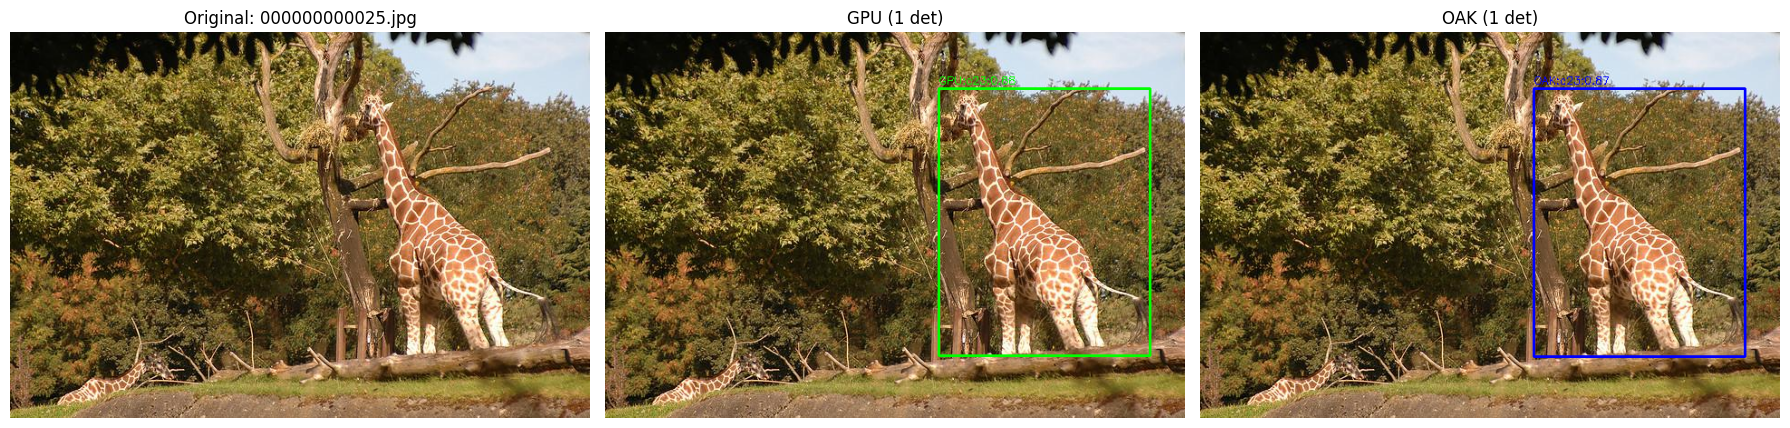



=== 000000000030.jpg ===
GPU: 2 detections, OAK: 2 detections

Top-5 boxes GPU vs OAK (IoU matching):
  [1] GPU c75@0.91 box=[238,156,408,351]
      OAK c75@0.90 box=[238,156,408,351]
      IoU=0.997 ✓
  [2] GPU c58@0.65 box=[203,32,460,350]
      OAK c58@0.62 box=[203,32,460,350]
      IoU=0.997 ✓


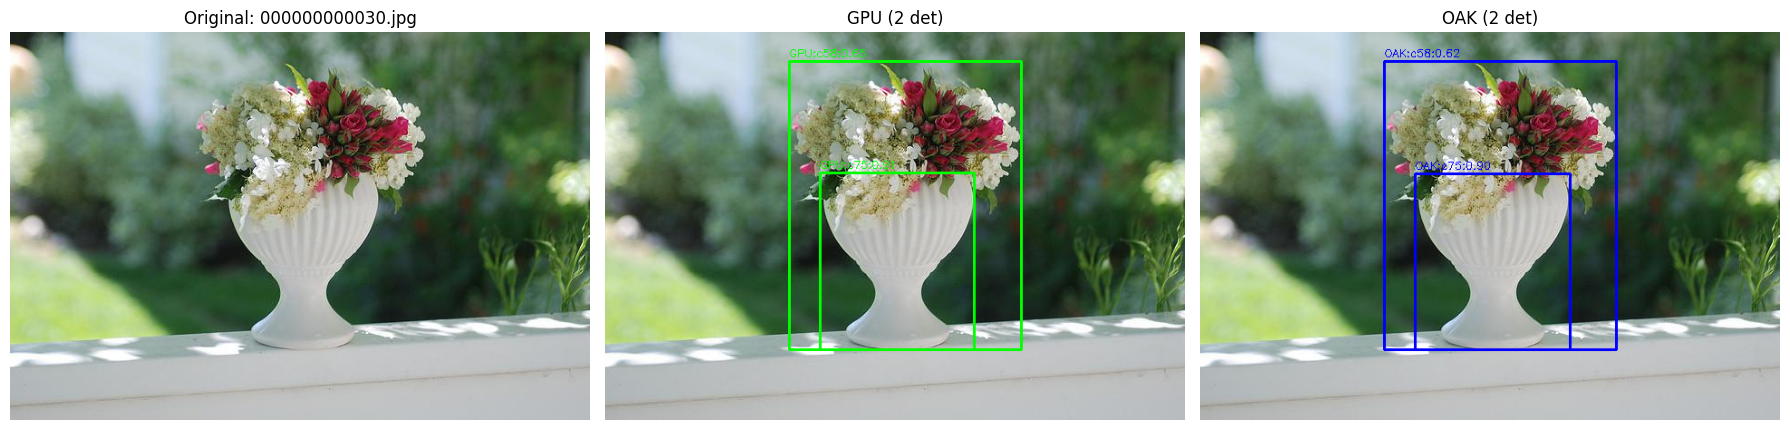



=== 000000000034.jpg ===
GPU: 1 detections, OAK: 1 detections

Top-5 boxes GPU vs OAK (IoU matching):
  [1] GPU c22@0.95 box=[1,22,441,402]
      OAK c22@0.95 box=[1,22,441,402]
      IoU=0.998 ✓


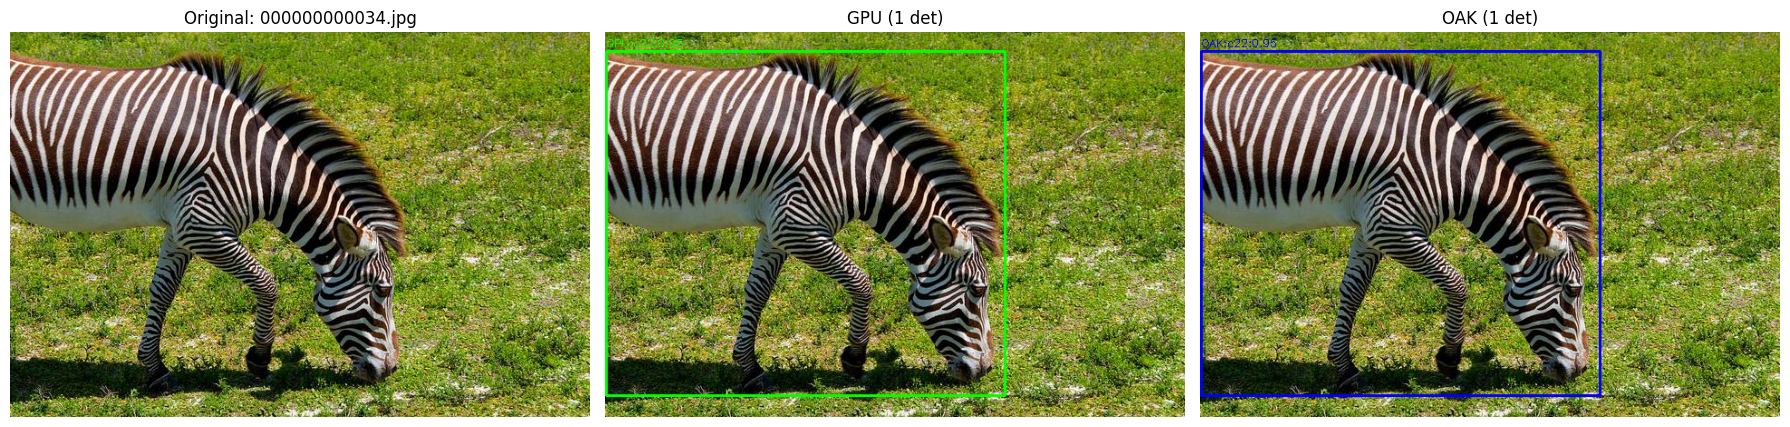



=== 000000000036.jpg ===
GPU: 2 detections, OAK: 2 detections

Top-5 boxes GPU vs OAK (IoU matching):
  [1] GPU c0@0.89 box=[174,158,465,640]
      OAK c0@0.89 box=[174,158,464,640]
      IoU=0.996 ✓
  [2] GPU c25@0.89 box=[1,54,455,490]
      OAK c25@0.88 box=[1,54,456,490]
      IoU=0.998 ✓


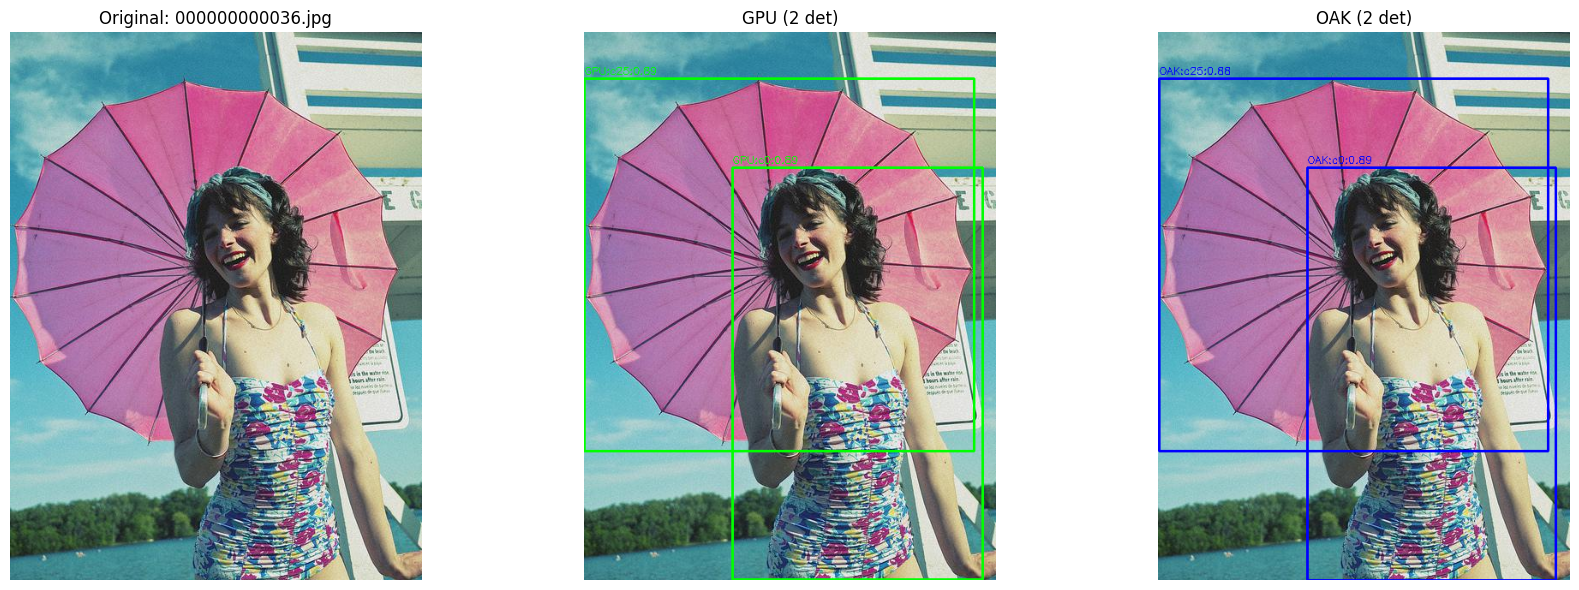

In [16]:
# Comparaison visuelle
print("Comparaison GPU vs OAK...\n")

with dai.Device(pipeline) as device:
    q_in = device.getInputQueue("input")
    q_out = device.getOutputQueue("nn", maxSize=1, blocking=True)
    
    for sample in test_images:
        img_path = sample['image_path']
        img = cv2.imread(img_path)
        img_name = Path(img_path).name
        
        # Inférences
        gpu_preds = run_gpu_inference(gpu_model, img, CONF_THR)
        oak_preds = run_oak_inference(device, q_in, q_out, img, NUM_CLASSES, CONF_THR)
        
        print(f"=== {img_name} ===")
        print(f"GPU: {len(gpu_preds)} detections, OAK: {len(oak_preds)} detections")
        
        # Matcher les boxes GPU/OAK par IoU
        print("\nTop-5 boxes GPU vs OAK (IoU matching):")
        gpu_sorted = sorted(gpu_preds, key=lambda x: x['confidence'], reverse=True)[:5]
        
        for i, gp in enumerate(gpu_sorted):
            best_iou = 0
            best_oak = None
            for op in oak_preds:
                if op['class_id'] == gp['class_id']:
                    iou = compute_box_iou(gp['box'], op['box'])
                    if iou > best_iou:
                        best_iou = iou
                        best_oak = op
            
            if best_oak:
                print(f"  [{i+1}] GPU c{gp['class_id']}@{gp['confidence']:.2f} "
                      f"box=[{gp['box'][0]:.0f},{gp['box'][1]:.0f},{gp['box'][2]:.0f},{gp['box'][3]:.0f}]")
                print(f"      OAK c{best_oak['class_id']}@{best_oak['confidence']:.2f} "
                      f"box=[{best_oak['box'][0]:.0f},{best_oak['box'][1]:.0f},{best_oak['box'][2]:.0f},{best_oak['box'][3]:.0f}]")
                print(f"      IoU={best_iou:.3f} {'✓' if best_iou > 0.9 else '⚠️ ATTENTION' if best_iou > 0.5 else '❌ PROBLEME'}")
            else:
                print(f"  [{i+1}] GPU c{gp['class_id']}@{gp['confidence']:.2f} -> PAS DE MATCH OAK")
        
        # Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Image originale
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Original: {img_name}")
        axes[0].axis('off')
        
        # GPU (vert)
        img_gpu = draw_boxes(img, gpu_preds, (0, 255, 0), 'GPU:')
        axes[1].imshow(cv2.cvtColor(img_gpu, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"GPU ({len(gpu_preds)} det)")
        axes[1].axis('off')
        
        # OAK (bleu)
        img_oak = draw_boxes(img, oak_preds, (255, 0, 0), 'OAK:')
        axes[2].imshow(cv2.cvtColor(img_oak, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f"OAK ({len(oak_preds)} det)")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        print("\n" + "="*60 + "\n")

In [17]:
# Résumé statistique
print("\n" + "="*60)
print("RÉSUMÉ")
print("="*60)
print("""
Si les IoU sont > 0.9 pour les top boxes, le décodage est cohérent.
Si les boxes sont systématiquement décalées/étirées, vérifiez:
  1. Le format cx,cy,w,h vs x,y,w,h
  2. L'ordre des coordonnées dans le tenseur
  3. Le reverse letterbox (ratio et padding)
""")


RÉSUMÉ

Si les IoU sont > 0.9 pour les top boxes, le décodage est cohérent.
Si les boxes sont systématiquement décalées/étirées, vérifiez:
  1. Le format cx,cy,w,h vs x,y,w,h
  2. L'ordre des coordonnées dans le tenseur
  3. Le reverse letterbox (ratio et padding)

